<a href="https://colab.research.google.com/github/pareshrchaudhary/colab/blob/main/homework/hw_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AA/EE/ME 548: Homework 04

## Name: Paresh R. Chaudhary

### Export page instructions:
Make sure all the text and figures are shown in your PDF print out. Try zooming out / widening your browser window etc when you print to PDF. Whatever needs to be done so that all the relevant content is shown in the PDF.

### Homework feedback:

**What was the coolest thing(s) you learned from lectures/homework that you didn't know previously?**


**Which problem did you find the most challenging and why?**


**Approximate how long did you spend on this homework?**


**Feedback on this homework (can improve for future hw and years)**


## Submission details
To submit your homework, please save a PDF copy of your notebook (make sure all the cells are run correctly, and the correct outputs are displayed), and submit via Canvas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cvxpy as cp
plt.style.use('seaborn-ticks')

<ipython-input-1-df9ee3ad974c>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


## Problem 1

You may find the following code template useful. But you are not required to use it if you / feel free to edit it however you like / write your own version of the code





In [ ]:
def mpc_step(A_dyn, B_dyn, Q, R, Qt, current_state, goal_state, u_max, MPC_horizon):
  us = cp.Variable([MPC_horizon,m], name="controls")
  xs = cp.Variable([MPC_horizon+1,n], name="states")
  initial_state = cp.Parameter(n, name="initial_state")
  cost = 0
  constraints = []

  for t in range(MPC_horizon):
    cost += cp.quad_form(xs[t]-goal_state, Q) + cp.quad_form(us[t], R)  # running cost
    constraints += [xs[t + 1,:] == A_dyn @ xs[t,:] + B_dyn @ us[t,:]]
    constraints += [cp.norm2(us[t,:]) <= u_max]

  cost += cp.quad_form(xs[MPC_horizon]-goal_state, Qt)  # terminal
  constraints += [xs[0] == initial_state]

  problem = cp.Problem(cp.Minimize(cost), constraints)
  problem.parameters()[0].value = current_state
  problem.solve()
  return problem.variables()[0].value, problem.variables()[1].value

In [ ]:
dt = 0.1    # time step size
n = 4   # state dim
m = 2   # control dim

Q = np.diag([5., 5., 1., 1.]) #cost
Qt = np.eye(n) * 8.0    #cost
R = np.diag([1., 1.])   #cost
goal_state = np.zeros(n)    #final
initial_state = np.array([-4, 0., 0., 2.])  #initial
u_max = 2  # constraint: maximum control magnitude
N_MPC_horizon = 10  # iter
N_total_horizon = 50  # iter total

Sigma_vec = np.array([0.0, 0.0, .1, .1])
np.random.seed(seed=123)
noise_vec = np.random.randn(N_MPC_horizon, n) * Sigma_vec

A_dynamics = np.array([[1., 0., dt, 0.],
                        [0., 1., 0., dt],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])

B_dynamics = np.array([[0.5 * dt**2, 0.],
                        [0., 0.5 * dt**2],
                        [dt, 0.],
                        [0., dt]])  

def simulate_system(initial_state, controls, noise_vec):
    '''
    initial_state has size [n,]
    controls has size [T,m]
    noise_vec has size [T,n]
    '''

    T = controls.shape[0]
    n = initial_state.shape[0]
    states = np.zeros([T+1, n])
    states[0] = initial_state
    for (t,ctrl) in enumerate(controls):
        states[t+1] = A_dynamics @ states[t] + B_dynamics @ ctrl + noise_vec[t]
    return states

In [ ]:
xs, us = mpc_step(A_dynamics, B_dynamics, Q, R, Qt, initial_state, goal_state, u_max, N_MPC_horizon)

### (a)

In [ ]:
MPC_states =  xs # size [time_horizon+1, n]
MPC_controls = us   # size [time_horizon, m]
true_states = simulate_system(initial_state, MPC_controls, noise_vec)  # size [time_horizon+1, n]

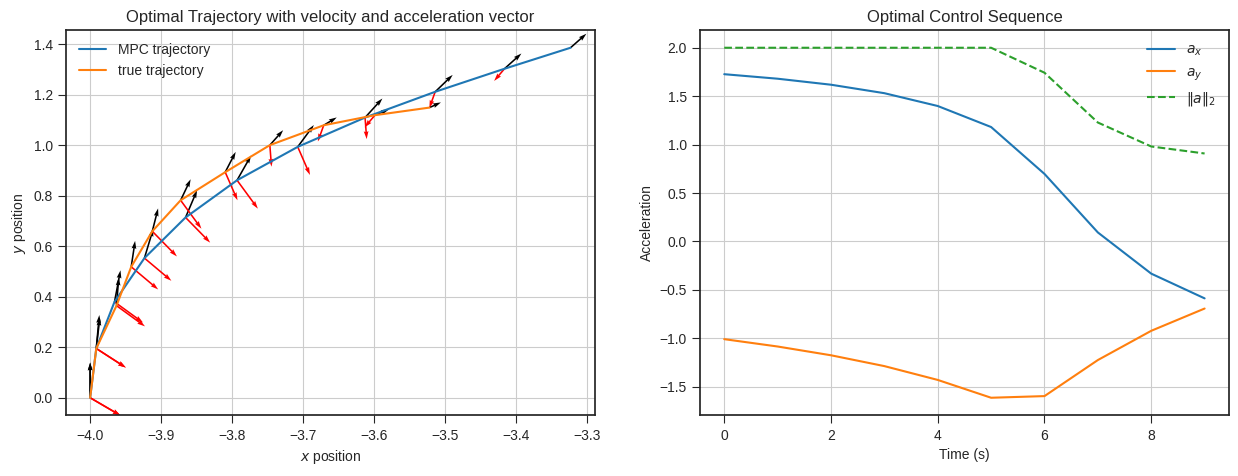

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(MPC_states[:,0], MPC_states[:,1], label="MPC trajectory")
plt.quiver(MPC_states[:,0], MPC_states[:,1], MPC_states[:,2], MPC_states[:,3], scale=30, width=.003)
plt.quiver(MPC_states[:-1,0], MPC_states[:-1,1], MPC_controls[:,0], MPC_controls[:,1], scale=30, width=.003, color='red')

plt.plot(true_states[:,0], true_states[:,1], label="true trajectory")
plt.quiver(true_states[:,0], true_states[:,1], true_states[:,2], true_states[:,3], scale=30, width=.003)
plt.quiver(true_states[:-1,0], true_states[:-1,1], MPC_controls[:,0], MPC_controls[:,1], scale=30, width=.003, color='red')
plt.title("Optimal Trajectory with velocity and acceleration vector")
plt.legend()
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(MPC_controls)
plt.plot(np.linalg.norm(MPC_controls, 2, axis=1), '--')
plt.title("Optimal Control Sequence")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["$a_x$", "$a_y$", "$\|a\|_2$"])
plt.grid()

### (b)

In [ ]:
# pre-defining the noise applied to the system
np.random.seed(seed=123) # play around with different seeds
noise_vec = np.random.randn(N_total_horizon, n) * np.array([0.0, 0.0, .1, .1])

In [ ]:
ol_us = cp.Variable([N_total_horizon,m], name="controls")
ol_xs = cp.Variable([N_total_horizon+1,n], name="states")
cost = 0
constraints = []


for t in range(N_total_horizon-1):
  cost += cp.quad_form(ol_xs[t], Q) + cp.quad_form(ol_us[t], R)  # running cost
  constraints += [ol_xs[t+1,:] == A_dynamics @ ol_xs[t,:] + B_dynamics @ ol_us[t,:], cp.norm2(ol_us[t,:]) <= u_max]

cost += cp.quad_form(ol_xs[-1], Qt)  # terminal
constraints += [ol_xs[0,:] == initial_state, ol_xs[-1,:] == goal_state] # 0th
problem = cp.Problem(cp.Minimize(cost), constraints)

problem.solve()
OL_xs = ol_xs.value[0:N_total_horizon] 
OL_us = ol_us.value[0:N_total_horizon-1]

In [ ]:
OL_xs = simulate_system(initial_state, OL_us, noise_vec)

In [ ]:
traj_states = np.zeros((N_total_horizon+1, n))
traj_controls = np.zeros((N_total_horizon, m))
current_state = initial_state

for i in range(N_total_horizon):
  xs_val, us_val = mpc_step(A_dynamics, B_dynamics, Q, R, Qt, current_state, goal_state, u_max, N_MPC_horizon)
  traj_states[i, :] = xs_val[0, :]
  traj_controls[i, :] = us_val[0, :]
  xs_noise = A_dynamics @ xs_val[0] + B_dynamics @ us_val[0] + noise_vec[i]
  current_state = xs_noise

In [ ]:
MPC_states = traj_states[0:N_total_horizon] # size [time_horizon+1, n]
MPC_controls = traj_controls[0:N_total_horizon-1]  # size [time_horizon, n]
OL_states = OL_xs[0:N_total_horizon]  # size [time_horizon+1, n]
OL_controls = OL_us[0:N_total_horizon-1]  # size [time_horizon, n]

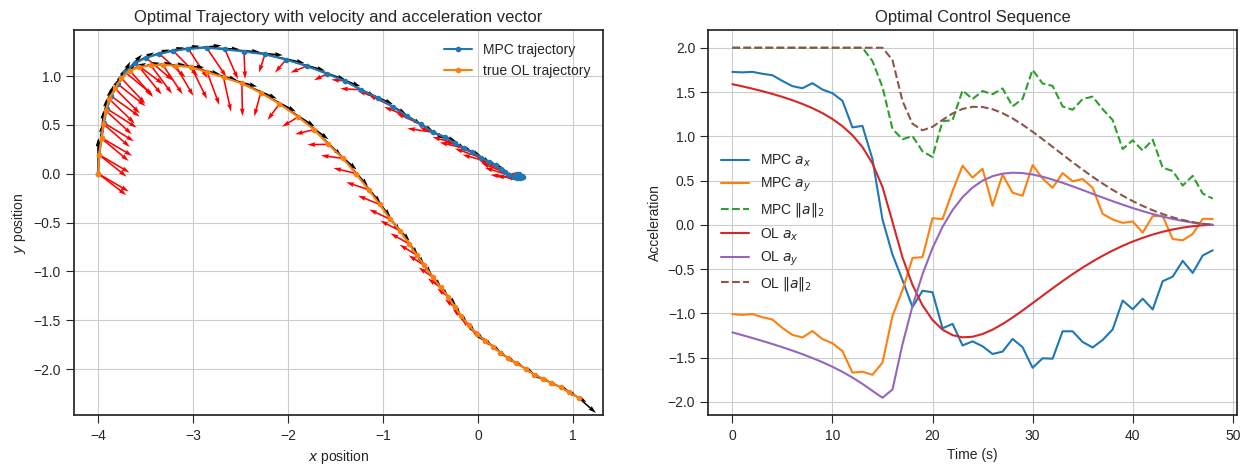

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(MPC_states[:,0], MPC_states[:,1], label="MPC trajectory", marker='.')
plt.plot(OL_states[:,0], OL_states[:,1], label="true OL trajectory", marker='.')
plt.quiver(MPC_states[:,0], MPC_states[:,1], MPC_states[:,2], MPC_states[:,3], scale=30, width=.003)
plt.quiver(MPC_states[:-1,0], MPC_states[:-1,1], MPC_controls[:,0], MPC_controls[:,1], scale=30, width=.003, color='red')
plt.quiver(OL_states[:,0], OL_states[:,1], OL_states[:,2], OL_states[:,3], scale=30, width=.003)
plt.quiver(OL_states[:-1,0], OL_states[:-1,1], OL_controls[:,0], OL_controls[:,1], scale=30, width=.003, color='red')

plt.title("Optimal Trajectory with velocity and acceleration vector")
plt.legend()
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(MPC_controls)
plt.plot(np.linalg.norm(MPC_controls, 2, axis=1), '--')

plt.plot(OL_controls)
plt.plot(np.linalg.norm(OL_controls, 2, axis=1), '--')

plt.title("Optimal Control Sequence")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["MPC $a_x$", "MPC $a_y$", "MPC $\|a\|_2$", "OL $a_x$", "OL $a_y$", "OL $\|a\|_2$"])
plt.grid()

# Problem 2 Kalman Filter

## (a)

\begin{align*}
Cov(X,W|Y) &= \int_{w} \int_{x} (w-\mu_{w|y})(x-\mu_{x|y})^Tp(x,w|y) \,dxdw 
\\
\\
Cov(X,W|Y) &= \int_{w} \int_{x} (w-\mu_{w})(x-\mu_{x|y})^T\frac{p(x,y,w)}{p(y)} \,dxdw 
\\
\\
\text{since, } p(x,y,w)&=p(x,y)p(w) \implies w \text{ is independent of } x \text{ and } y \implies \mu_{w|y}=\mu_{w} 
\\
\\
Cov(X,W|Y) &= \int_{w} \int_{x} (w-\mu_{w})(x-\mu_{x|y})^T\frac{p(x,y)p(w)}{p(y)} \,dxdw 
\\
\\
\text{since it is given that } p(x,y,w)&=p(x,y)p(w) 
\\
\\
Cov(X,W|Y) &= \frac{1}{p(y)}\int_{w} \int_{x} (w-\mu_{w})(x-\mu_{x|y})^Tp(x,y)p(w) \,dxdw 
\\
\\
Cov(X,W|Y) &= \frac{1}{p(y)}\left(\int_{w}(w-\mu_{w})p(w) \,dw\right)\left(\int_{x}(x-\mu_{x|y})^Tp(x,y) \,dx\right) 
\\
\\
Cov(X,W|Y) &= \frac{1}{p(y)}\left(\int_{w}wp(w) \,dw - \mu_{w}\int_{w} p(w) \,dw\right)\left(\int_{x}(x-\mu_{x|y})^Tp(x,y) \,dx\right) 
\\
\\
Cov(X,W|Y) &= \frac{1}{p(y)}(\mu_{w} - \mu_{w})\left(\int_{x}(x-\mu_{x|y})^Tp(x,y) \,dx\right) = 0 \\
\text{Therefore}, \boxed{Cov(X,W|Y) = 0} \\
\end{align*}

## (b)

\begin{align*}
Cov(X,W|Y) &= \mathbb{E}[(X-\mathbb{E}[X|Y])(W-\mathbb{E}[W|Y])^{T}|Y] 
\\
\\
Cov(X_{t},W_{t}|Y_{1:t}) &= \mathbb{E}[(X_{t}-\mathbb{E}[X_{t}|Y_{1:t}])(W_{t}-\mathbb{E}[W_{t}|Y_{1:t}])^{T}|Y_{1:t}] 
\\
\\
\text{Since } W_{t} \text{ is Gaussian white noise, } \mathbb{E}[W_{t}]&=\mathbb{E}[W_{t}|Y_{1:t}]=0 
\\
\\
\implies Cov(X_{t},W_{t}|Y_{1:t}) &= \mathbb{E}[(X_{t}-\mathbb{E}[X_{t}|Y_{1:t}])W_{t}^{T}|Y_{1:t}] 
\\
\\
\text{Let } \mathbb{E}[X_{t}|Y_{1:t}]&=\mu_{t|t} 
\\
\\
\implies Cov(X_{t},W_{t}|Y_{1:t}) &= \mathbb{E}[(X_{t}-\mu_{t|t})W_{t}^{T}|Y_{1:t}] 
\\
\\
\text{From (a), } Cov(X,W|Y) &= Cov(X_{t},W_{t}|Y_{1:t}) = 0 
\\
\\
\therefore \mathbb{E}[(X_{t}-\mu_{t|t})W_{t}^{T}|Y_{1:t}] &= 0 \\
\end{align*}


## (c)

\begin{align*}
P_{t+1} &= \begin{bmatrix} x_{t+1} \\ y_{t+1} \end{bmatrix} \\
S_{t+1} &= \begin{bmatrix} s_{x(t+1)} \\ s_{y(t+1)} \end{bmatrix} \\
s_{x(t+1)} &= s_{x(t)} + a_x\delta t + W_t \\
s_{y(t+1)} &= s_{y(t)} + a_y\delta t + W_t \\
x_{t+1} &= x_{t} + s_{x(t)}\delta t \\
y_{t+1} &= y_{t} + s_{y(t)}\delta t \\
\begin{bmatrix} x_{t+1} \\ y_{t+1} \\ {s_x}_{t+1} \\ {s_y}_{t+1} \end{bmatrix} &= \begin{bmatrix} x_{t} + s_{x(t)}\delta t \\ y_{t} + s_{y(t)}\delta t \\ s_{x(t)} + a_x\delta t + W_t \\ s_{y(t)} + a_y\delta t + W_t\end{bmatrix} \\
\begin{bmatrix} x_{t+1} \\ y_{t+1} \\ {s_x}_{t+1} \\ {s_y}_{t+1} \end{bmatrix} &= \begin{bmatrix} 1&0&\delta t&0 \\ 0&1&0&\delta t \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix} \cdot \begin{bmatrix} x_t \\ y_t \\ {s_x}_t \\ {s_y}_t \end{bmatrix} + \begin{bmatrix} 0&0 \\ 0&0 \\ \delta t&0 \\ 0&\delta t \end{bmatrix} \cdot \begin{bmatrix} a_x \\ a_y \end{bmatrix} + \begin{bmatrix} 0&0 \\ 0&0 \\ 1&0 \\ 0&1 \end{bmatrix} \cdot \begin{bmatrix} W_{tx} \\ W_{ty} \end{bmatrix}
\end{align*}

\begin{align*}
x_{\text{new}} &= Ax + Bu + W_t \\
\text{where,} \\
A &= \begin{bmatrix} 1&0&\delta t&0 \\ 0&1&0&\delta t \\ 0&0&1&0 \\ 0&0&0&1 \end{bmatrix} \\
B &= \begin{bmatrix} 0&0 \\ 0&0 \\ \delta t&0 \\ 0&\delta t \end{bmatrix} \\
\text{and,} \\
y &= Cx + Du, \quad D = 0 \\
y &= Cx \\
\text{We are making position measurements,} \\
C &= \begin{bmatrix} 1&0&0&0 \\ 0&1&0&0 \end{bmatrix}
\end{align*}







## (d)

In [ ]:
# your code here. Make sure you label your plot clearly
# Recommend using plt.plot and plt.scatter to clearly show the state at each time step
T =  60 
dt = 1
p_0 = [1000*m, 0*m]
s_0 = [0, 50]
ut = [-2.5*cos(0.05*t), -2.5*sin(0.05*t)] 

Q = 
R = 

## (e)

\begin{align*}
X_{t+1} &= AX_{t} + Bu_{t} + \begin{bmatrix} 0&0 \\ 0&0 \\ 1&0 \\ 0&1 \end{bmatrix}W_{t} = AX_{t} + Bu_{t} + W^{new}_{t} \\
\text{where, } \
W_t^{new} &= \begin{bmatrix} 0&0 \\ 0&0 \\ 1&0 \\ 0&1 \end{bmatrix} \cdot W_t \\
\text{Let } M &= \begin{bmatrix} 0&0 \\ 0&0 \\ 1&0 \\ 0&1 \end{bmatrix} \\
\text{Mean of } W^{new}_{t} &= \mathbb{E}[W^{new}_{t}] = \mathbb{E}[MW_{t}] = M\mathbb{E}[W_{t}] = 0 \\
&\text{(since the mean of } W_{t} = \mathbb{E}[W_{t}] = 0, \text{ i.e., white noise)} \\
\text{Therefore, } \boxed{\mu^{new} = 0} \\
\text{Similarly, } \\
\text{Variance of } W^{new}_{t} &= \mathbb{E}[W^{new}_{t}(W^{new}_{t})^{T}] = \mathbb{E}[(MW_{t})(MW_{t})^{T}] = \mathbb{E}[M(W_{t})(W_{t})^{T}M^{T}] \\
\text{Variance of } W^{new}_{t} &= M\mathbb{E}[W_{t}(W_{t})^{T}]M^{T} = MQM^{T} \\
\text{where } Q \text{ is the variance of } W_{t} \\
\text{Therefore, } \\
Q^{new} &= MQM^{T} = \begin{bmatrix} 0&0 \\ 0&0 \\ 1&0 \\ 0&1 \end{bmatrix} Q \begin{bmatrix} 0&0&1&0 \\ 0&0&0&1 \end{bmatrix} \\
\boxed{Q^{new} = \begin{bmatrix} 0&0&0&0 \\ 0&0&0&0 \\ 0&0&Q&0 \\ 0&0&0&Q \end{bmatrix}}
\end{align*}






## (f)

In [ ]:
# you may find these plotting functionalities useful. Or you can use your own code

def create_95_ellipse_patch(mean, covariance):
    chi_95 = 5.991
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    vals, vecs = eigsorted(covariance)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2  * np.sqrt(vals * chi_95)
    return Ellipse(xy=mean, width=w, height=h, angle=theta)


def plot_95_ellipse(mean, covariance):
    chi_95 = 5.991
    mean = np.array([[mean[0]],[mean[1]]])
    val, rot = np.linalg.eig(covariance)
    val = np.sqrt(val * chi_95)
    t = np.linspace(0, 2.0 * np.pi, 1000)
    xy = np.stack((np.cos(t), np.sin(t)), axis=-1)

    plt.plot(*(rot @ (val * xy).T + mean))
    plt.fill(*(rot @ (val * xy).T + mean), alpha=0.3)

In [ ]:
# your code

## (g)

In [ ]:
# your code

## (h)

In [ ]:
# your code 